This is practically copied from the following:
* [How to do Deep Learning on Graphs with Graph Convolutional Networks - Tobias Jepsen](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)  

Tobias was inspired by this post:
* [Graph Convolutional Networks - Thomas Kipf](http://tkipf.github.io/graph-convolutional-networks/)

# Basics of Graph convolutions

To define a graph with nodes (with features) and vertices, we need two matrices. We need a way to define which node is connected to which other node with an adjecency matrix `A`. We also need a feature matrix where the features of each nodes are defined with matrix `X`

In [64]:
import numpy as np

In [3]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]
])

In [7]:
X = np.matrix([
    [ 0.,  0.],
    [ 1., -1.],
    [ 2., -2.],
    [ 3., -3.]
])

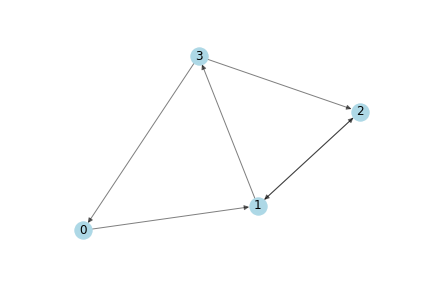

In [17]:
from IPython.display import Image
Image(filename='graph.png',width=400, height=200)

The graph gets the value from the locations where the arrows point at.

To propagate the information one step `A` and `X` need to be multiplied.

In [6]:
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

Currently, the information that is in the node before teh propagation step is lost. Now add the Identity matrix to `A` to not loose the original feature matrix.

In [21]:
A_hat = A + np.eye(A.shape[0])
A_hat

matrix([[1., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 1.]])

In [22]:
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Nodes with many connections will explode and nodes with few connections will vanish, this calls for normalization. Intuitively, nodes with many connections should have connections that are smaller in size. This is exactly what the 'inverse degree matrix' does. It is multiplied with the adjecency matrix to get a scaled adjecency matrix.

In [37]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
# D = array([2., 3., 3., 2.])
D_hat = np.matrix(np.diag(D_hat))
print('D_hat**-1:\n', D_hat**-1, '\n')
print('D_hat**-1 * A: \n', D_hat**-1 * A)

D_hat**-1:
 [[0.5        0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.5       ]] 

D_hat**-1 * A: 
 [[0.         0.5        0.         0.        ]
 [0.         0.         0.33333333 0.33333333]
 [0.         0.33333333 0.         0.        ]
 [0.5        0.         0.5        0.        ]]


Propagation with the normalized adjecency matrix then looks as follows:

In [38]:
D_hat**-1 * A_hat * X

matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

In the next step we'll add weights. The weight matrix determines the dimension of the next 'layer'.

In [48]:
W_2 = np.matrix([
    [1, -1],
    [-1, 1]
])

In [49]:
D_hat**-1 * A_hat * X * W_2

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

Now try the same with a weigth matrix that reduces the dimensionality.

In [50]:
W_1 = np.matrix([
    [1],
    [-1]
])

In [51]:
D_hat**-1 * A_hat * X * W_1

matrix([[1.],
        [4.],
        [2.],
        [5.]])

Adding relu:

In [62]:
def relu(M):
    return np.maximum(M, 0)

In [63]:
relu(D_hat**-1 * A_hat * X * W_2)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])